In [52]:
import numpy as np
import collections
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score


# # Step 1: Load the image
# image_path = 'inference_images2/Bolivia_103757_S2Hand/certainty_arr20.npy'  # Replace with your image path
# image_array = np.load(image_path)

# # Step 2: Flatten the array
# flattened_array = image_array.flatten()

# # Step 3: Exclude 0 and 1 from the array
# filtered_array = flattened_array[(flattened_array != 0) & (flattened_array != 1)]

# # Step 4: Calculate the distribution
# value_counts = collections.Counter(filtered_array)

# # Step 5: Visualize the distribution
# plt.figure(figsize=(10, 6))
# plt.hist(filtered_array, bins=50, color='blue', edgecolor='black')
# plt.title('Distribution of Non-zero and Non-one Values')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()


To calculate calibration, we have to calculate per-percentage y, the rate, x at which y-certain pixels are correct. If x is extremely close to y, the certainty estimation is well calibrated.

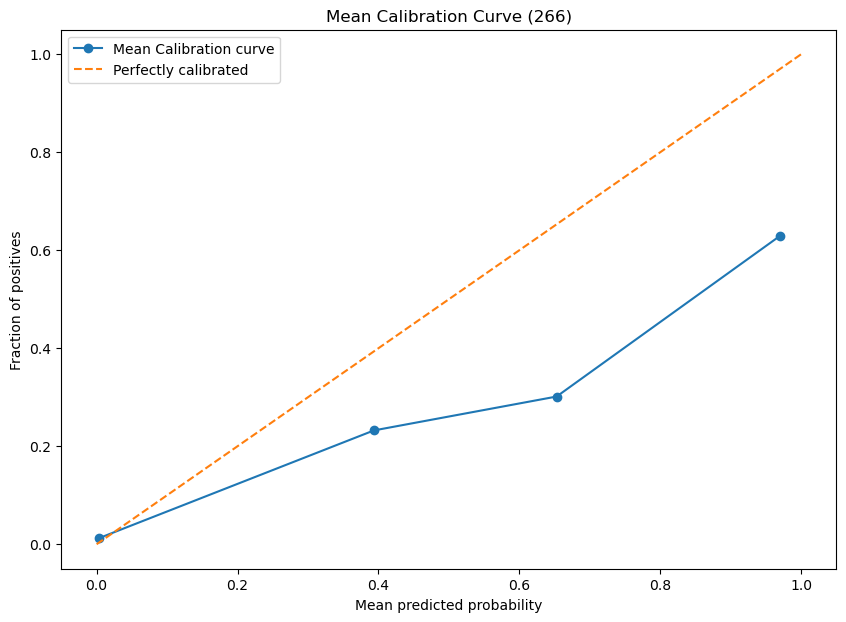

Expected Calibration Error (ECE): 0.2382


In [379]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

def compute_ece(prob_trues, prob_preds, n_bins):
    ece = 0.0
    total_samples = sum(len(prob_true) for prob_true in prob_trues)
    
    for i in range(len(prob_trues)):
        bin_size = len(prob_trues[i])
        bin_weight = bin_size / total_samples
        abs_diff = np.abs(prob_trues[i] - prob_preds[i])
        ece += bin_weight * np.sum(abs_diff) / n_bins
    
    return ece

n_montecarlo = 20
n_bins = 4
directory = "inference_images3"
isotonic_X = []
isotonic_y = []
prob_trues = []
prob_preds = []
img_count = 0
for filename in os.listdir(directory):
    if filename == ".ipynb_checkpoints":
        continue

    imgname = filename.split("_")
    filepath = os.path.join(directory, filename)
    if not os.path.exists(f"{filepath}/groundtruth_arr{n_montecarlo}.npy"):
        continue
    gt_arr = np.load(f"{filepath}/groundtruth_arr{n_montecarlo}.npy")
    certainty_pred = np.load(f"{filepath}/certainty_arr{n_montecarlo}.npy")

    # Replace NaN values with 0
    gt_arr = np.nan_to_num(gt_arr, nan=0)
    certainty_pred = np.nan_to_num(certainty_pred, nan=0)

    
    gt_arr = np.where(gt_arr == -1, 0, gt_arr)

        
    # Flatten arrays
    gt_arr = gt_arr.flatten()
    certainty_pred = certainty_pred.flatten()
    # Compute calibration curve for the current image
    prob_true, prob_pred = calibration_curve(gt_arr, certainty_pred, n_bins=n_bins)
    
    # Check shapes
    if len(prob_true) != len(prob_pred):
        print(f"Warning: Different lengths of prob_true ({len(prob_true)}) and prob_pred ({len(prob_pred)}) for file {filename}")
    if prob_true.shape[0] < n_bins:
        continue
    # Append to lists
    isotonic_X.append(certainty_pred)
    isotonic_y.append(gt_arr)
    
    prob_trues.append(prob_true)
    prob_preds.append(prob_pred)
    img_count+=1
# Compute the mean calibration curve
mean_prob_true = np.mean(prob_trues, axis=0)
mean_prob_pred = np.mean(prob_preds, axis=0)

# Plot the mean calibration curve
plt.figure(figsize=(10, 7))
plt.plot(mean_prob_pred, mean_prob_true, marker='o', label='Mean Calibration curve')

# Plot the perfect calibration line
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title(f'Mean Calibration Curve ({img_count})')
plt.legend()
plt.show()

# Calculate ECE
ece = compute_ece(prob_trues, prob_preds, n_bins=n_bins)
print(f'Expected Calibration Error (ECE): {ece:.4f}')


Improve calibration with isotonic regression --> then, test calibration again

In [362]:
from sklearn.calibration import IsotonicRegression

X = np.concatenate([np.array(x) for x in isotonic_X])
y = np.concatenate([np.array(y) for y in isotonic_y])

isotonic = IsotonicRegression(out_of_bounds='clip',
                              y_min=0,
                              y_max=1)
isotonic.fit(X, y)
isotonic_probs = isotonic.predict(isotonic_X[1])
print(np.unique(isotonic_probs))

[0.00699811 0.09744481 0.12059832 0.14020428 0.18205148 0.22169591
 0.22383786 0.26063557 0.28186723 0.30078076 0.34161663 0.36168436
 0.4094607  0.44865307 0.50329312 0.82367703 0.83788728]


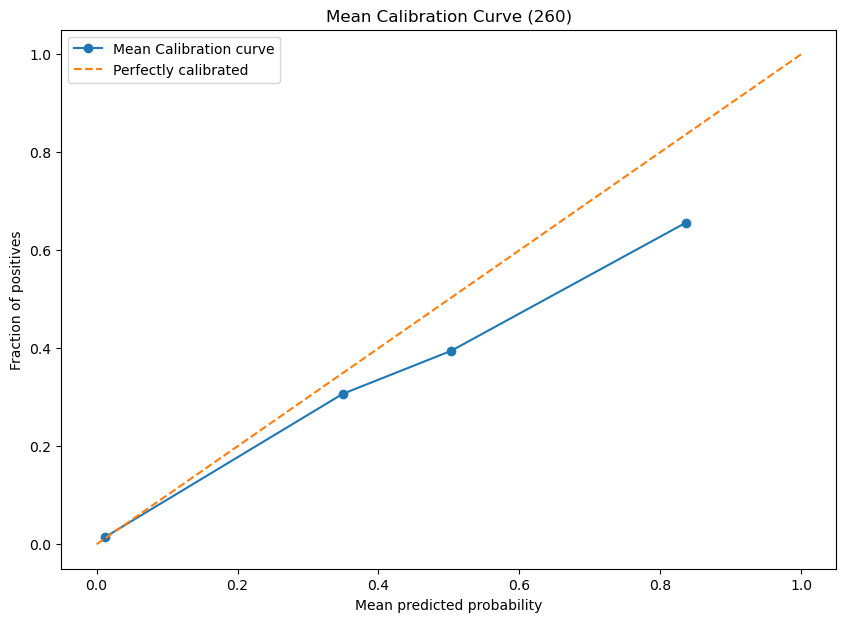

Expected Calibration Error (ECE): 0.1662


In [383]:
prob_trues = []
prob_preds = []
n_bins=4
img_count = 0
for filename in os.listdir(directory):
    if filename == ".ipynb_checkpoints":
        continue

    imgname = filename.split("_")
    filepath = os.path.join(directory, filename)
    if not os.path.exists(f"{filepath}/groundtruth_arr{n_montecarlo}.npy"):
        continue
    gt_arr = np.load(f"{filepath}/groundtruth_arr{n_montecarlo}.npy")
    certainty_pred = np.load(f"{filepath}/certainty_arr{n_montecarlo}.npy")

    # Replace NaN values with 0
    gt_arr = np.nan_to_num(gt_arr, nan=0)
    certainty_pred = np.nan_to_num(certainty_pred, nan=0)

    
    gt_arr = np.where(gt_arr == -1, 0, gt_arr)

        
    # Flatten arrays
    gt_arr = gt_arr.flatten()
    certainty_pred = certainty_pred.flatten()
    certainty_pred = isotonic.predict(certainty_pred)
    # Compute calibration curve for the current image
    prob_true, prob_pred = calibration_curve(gt_arr, certainty_pred, n_bins=n_bins)
    
    # Check shapes
    if len(prob_true) != len(prob_pred):
        print(f"Warning: Different lengths of prob_true ({len(prob_true)}) and prob_pred ({len(prob_pred)}) for file {filename}")
    if prob_true.shape[0] < n_bins:
        continue
    # Append to lists
    isotonic_X.append(certainty_pred)
    isotonic_y.append(gt_arr)
    
    prob_trues.append(prob_true)
    prob_preds.append(prob_pred)
    img_count+=1
# Compute the mean calibration curve
mean_prob_true = np.mean(prob_trues, axis=0)
mean_prob_pred = np.mean(prob_preds, axis=0)

# Plot the mean calibration curve
plt.figure(figsize=(10, 7))
plt.plot(mean_prob_pred, mean_prob_true, marker='o', label='Mean Calibration curve')

# Plot the perfect calibration line
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title(f'Mean Calibration Curve ({img_count})')
plt.legend()
plt.show()

# Calculate ECE
ece = compute_ece(prob_trues, prob_preds, n_bins=n_bins)
print(f'Expected Calibration Error (ECE): {ece:.4f}')


We combine our certainty estimation (variance array) with our original prediction to generate a 3 different predictions: more strict, more free, and regular.

We evaluate these composites on ground truth data.

In [ ]:
# Turning pixels with 80th percentile+ variance to no flood pixels. Expected Result: A more conservative prediction, better F1 score
# (good precision AND good recall) --> model gets positives right, and does not have too many false positives

In [ ]:
n_montecarlo = 20
n_bins = 10
directory = "inference_images2"
test_res = {}
prob_trues = []
prob_preds = []

for filename in os.listdir(directory):
    if filename == ".ipynb_checkpoints":
        continue

    imgname = filename.split("_")
    filepath = os.path.join(directory, filename)

    gt_arr = np.load(f"{filepath}/groundtruth_arr{n_montecarlo}.npy")
    orig_pred = np.load(f"{filepath}/original_pred{n_montecarlo}.npy")
    var_pred = np.load(f"{filepath}/variance_arr{n_montecarlo}.npy")

    gt_arr.flatten()
    orig_pred.flatten()
    var_pred.flatten()

    threshold = np.percentile(var_pred, 80)

    var_pred = np.where(var_pred >= threshold, 1, 0)
    gt_arr = np.where(gt_arr == -1, 0, gt_arr)



    composite_pred = orig_pred * var_pred

    test_res[filename] = [f1_score(gt_arr, orig_pred), f1_score(gt_arr, composite_pred), f1_score(gt_arr, composite_pred) - f1_score(gt_arr, orig_pred)]

    # if np.sum(gt_arr == 1) < 500:
    #     continue

    # gt_arr = gt_arr.flatten()
    # orig_pred = orig_pred.flatten()

print(test_res)
